# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

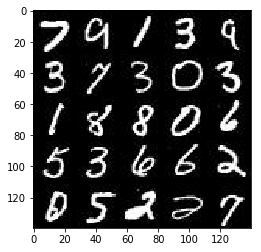

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

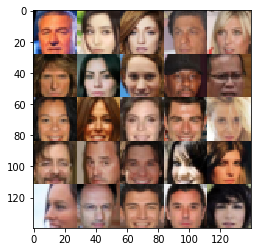

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    tensor_of_real_input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    tensor_of_z_data = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return tensor_of_real_input_images, tensor_of_z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [13]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        
        # Layer 1; convloution kernal = 5, subsample stride = 2, 32x32x3 => 16x16x32
        conv1 = tf.layers.conv2d(images, 32, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha*conv1, conv1) 

        # Layer 2; convloution 16x16x32 => 8x8x64
        conv2 = tf.layers.conv2d(conv1, 64, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        # Layer 3; convloution 8x8x64 => 4x4x128
        conv3 = tf.layers.conv2d(conv2, 128, 5, strides=2, activation=None, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3) 

        # flatten the convolution to feed into the fully connected layers
        size = conv3.get_shape().as_list()
        feature_size = size[1]*size[2]*size[3] 
        flatten = tf.reshape(conv3, (-1, feature_size))
        
        # Layer 4; Fully connect, 32x32x128 = 2048 => 512
        den1 = tf.layers.dense(flatten, feature_size//4, use_bias=False)
        den1 = tf.layers.batch_normalization(den1, training=True)
        den1 = tf.maximum(alpha*den1, den1)
        
        # Layer 5; Fully connect, 512 => 128
        den2 = tf.layers.dense(den1, feature_size//16, use_bias=False)
        den2 = tf.layers.batch_normalization(den2, training=True)
        den2 = tf.maximum(alpha*den2, den2)
        
        # Layer 6; Fully connect, 128 => 1
        logits = tf.layers.dense(den2, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4 * 4 * 512)     
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding="valid")
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding="same")
        outputs = tf.tanh(logits)
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    fake = generator(input_z, out_channel_dim, is_train=True)
    d_logits_fake = discriminator(fake, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_logits_real) * (0.9)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)  
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # create tensorboard session at location log_path and save the graph there
        log_path = '/tmp/tensorboard/data/mnist'
        writer = tf.summary.FileWriter(log_path, graph=sess.graph)
    
        for epoch_i in range(epoch_count):
            for image in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                image = image*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(100, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: image, inputs_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                #_ = sess.run(g_opt, feed_dict={inputs_z: batch_z, learn_rate: learning_rate})
                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: image})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 200 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                    
        # display rge output of the trained network
        show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode) 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5923... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.5615... Generator Loss: 0.4903
Epoch 1/2... Discriminator Loss: 1.5487... Generator Loss: 0.4853
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.4808
Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.5094
Epoch 1/2... Discriminator Loss: 1.4320... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.5317
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.5517


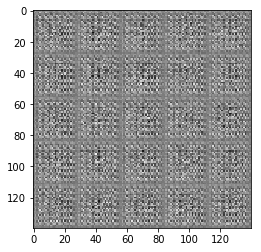

Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 0.5663
Epoch 1/2... Discriminator Loss: 1.3623... Generator Loss: 0.5857
Epoch 1/2... Discriminator Loss: 1.3567... Generator Loss: 0.5713
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.5799
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.5849
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.5940
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.5921
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.6130
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.5893


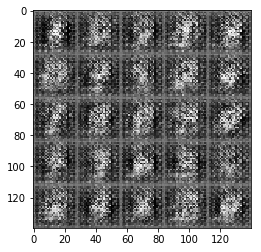

Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.5958
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.5861
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.6068
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.2847... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 0.6129
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.3443... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.6309


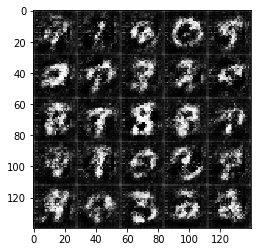

Epoch 1/2... Discriminator Loss: 1.2858... Generator Loss: 0.6418
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 0.5993
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.6266
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.6402
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.6395
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.2358... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.6454


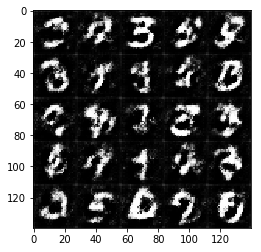

Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.6442
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.6533
Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 1.2881... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 1.3045... Generator Loss: 0.6076


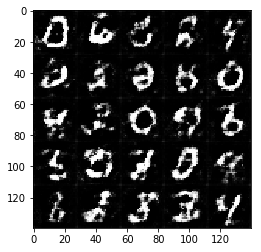

Epoch 2/2... Discriminator Loss: 1.3108... Generator Loss: 0.6148
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.6534
Epoch 2/2... Discriminator Loss: 1.2759... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.6079
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 0.6095
Epoch 2/2... Discriminator Loss: 1.2487... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 1.3018... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.6802
Epoch 2/2... Discriminator Loss: 1.3037... Generator Loss: 0.5762


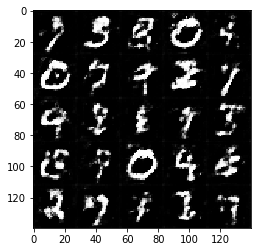

Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.6424
Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.6459
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.6390
Epoch 2/2... Discriminator Loss: 1.2283... Generator Loss: 0.6640
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 0.6551
Epoch 2/2... Discriminator Loss: 1.2381... Generator Loss: 0.6453
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.6445
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.6926
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.6687


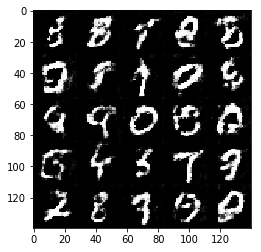

Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.6806
Epoch 2/2... Discriminator Loss: 1.1807... Generator Loss: 0.6723
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.6776
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 1.1559... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 0.6494
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.1986... Generator Loss: 0.6955


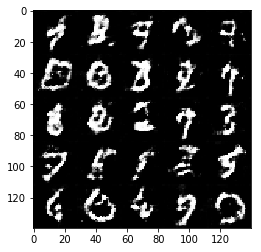

Epoch 2/2... Discriminator Loss: 1.2059... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 1.1849... Generator Loss: 0.6678
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.1323... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.1426... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.6682
Epoch 2/2... Discriminator Loss: 1.2085... Generator Loss: 0.6535
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 0.6099


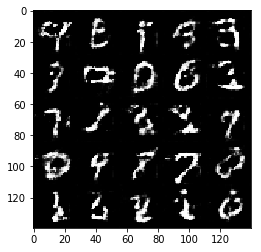

Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.6853


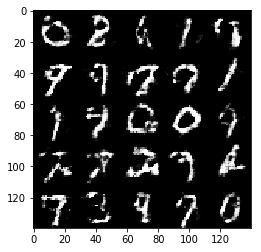

In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.5802... Generator Loss: 0.4762
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.4717
Epoch 1/1... Discriminator Loss: 1.5668... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.5235... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6006


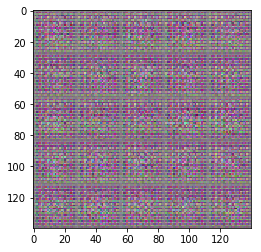

Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6314


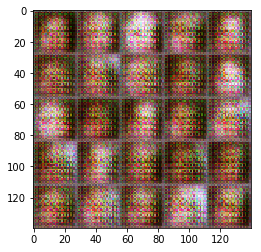

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5437


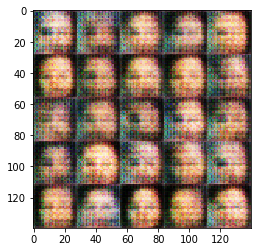

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.5956


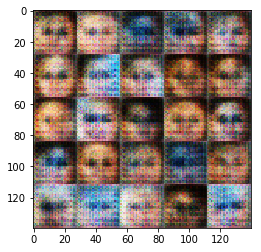

In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001 
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.